Intro To Neural Networks 1.5 pg 29 - Neural Network using MNIST

(1797, 64)


<Figure size 432x288 with 0 Axes>

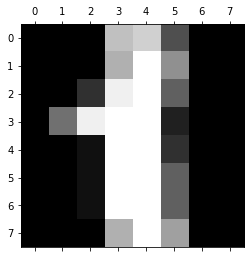

In [17]:
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.data.shape)
import matplotlib.pyplot as plt
plt.gray()
plt.matshow(digits.images[1])
plt.show()

1.5.1 Scaling Data - we are scaling the data to a small range centered around 0

In [18]:
digits.data[0,:]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

In [19]:
from sklearn.preprocessing import StandardScaler
X_scale = StandardScaler()
X = X_scale.fit_transform(digits.data)
X[0:,]

array([[ 0.        , -0.33501649, -0.04308102, ..., -1.14664746,
        -0.5056698 , -0.19600752],
       [ 0.        , -0.33501649, -1.09493684, ...,  0.54856067,
        -0.5056698 , -0.19600752],
       [ 0.        , -0.33501649, -1.09493684, ...,  1.56568555,
         1.6951369 , -0.19600752],
       ...,
       [ 0.        , -0.33501649, -0.88456568, ..., -0.12952258,
        -0.5056698 , -0.19600752],
       [ 0.        , -0.33501649, -0.67419451, ...,  0.8876023 ,
        -0.5056698 , -0.19600752],
       [ 0.        , -0.33501649,  1.00877481, ...,  0.8876023 ,
        -0.26113572, -0.19600752]])

1.5.2 Creating test and training datasets

In [33]:
# Splitting the data into test and train data. The test is 40% of the data and the train is 60% in this example
from sklearn.model_selection import train_test_split
y = digits.target #targets are the classification in this case the numbers 0 - 9
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4)

In [34]:
import numpy as np
def convert_y_to_vect(y):
    y_vect = np.zeros((len(y),10))
    for i in range(len(y)):
        y_vect[i, y[i]] = 1
    return y_vect
        

In [35]:
y_v_train = convert_y_to_vect(y_train)
y_v_test = convert_y_to_vect(y_test)

y_train[0], y_v_train[0]

(9, array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]))

1.5.4 Creating the Neural Network: 64 input nudes for the 64 pixels & 10 output layer nodes to classify & a hidden layer that usually has a number of nodes between the input and output layers

In [36]:
# This is the structure of our network [#nodes in input layer, #nodes in hidden layer, #nodes in output layer]
nn_structure = [64, 30, 10]

In [37]:
# I will use a sigmoid activation function and its derivative
# Sigmoid Activation Function
def f(x):
    return 1 / (1 + np.exp(-x))

In [38]:
# Derivative of Sigmoid Fucntion
def f_deriv(x):
    return f(x) * (1-f(x))

In [39]:
# Weight Initialization (with random values)
import numpy.random as r
def setup_and_init_weights(nn_structure):
    W = {}
    b = {}
    for l in range(1, len(nn_structure)):
        W[l] = r.random_sample((nn_structure[l], nn_structure[l-1]))
        b[l] = r.random_sample((nn_structure[l],))
    return W, b

The next step is to set the mean accumulation values ΔW and Δb to zero (they need to be
the same size as the weight and bias matrices):

In [40]:
def init_tri_values(nn_structure):
    tri_W = {}
    tri_b = {}
    for l in range(1, len(nn_structure)):
        tri_W[l] = np.zeros((nn_structure[l], nn_structure[l-1]))
        tri_b[l] = np.zeros((nn_structure[l],))
    return tri_W, tri_b

If we now step into the gradient descent loop, the first step is to perform a feed forward
pass through the network.

In [46]:
def feed_forward(x, W, b):
    h = {1:x}
    z = {}
    for l in range(1, len(W)+1):
        # if it is the first layer, then the input into the weights is x, 
        # otherwise it is the output from the last layer
        if l == 1:
            node_in = x
        else:
            node_in = h[l]
        z[l+1] = W[l].dot(node_in) + b[l] # z^(l+1) = W^(l)*h^(l) + b^(l)
        h[l+1] = f(z[l+1]) #h^(l) = f(z^(l))
    return h, z

Finally, we have to then calculate the output layer delta g(n1)
(note its the greek symbol that looks like a g) and any hidden layer 
delta values g(l) to perform the backpropagation pass

In [47]:
def calculate_out_layer_delta(y,h_out,z_out):
    # delta^(nl) =  -(y_i) - h_i^(nl)) *f(z_i^(nl))
    return -(y-h_out) * f_deriv(z_out)

In [48]:
def calculate_hidden_delta(delta_plus_1, w_l,z_l):
    # delta^(l) = (transpose(W^(l))* delta(l+1)) * f(z^(1))
    return np.dot(np.transpose(w_l), delta_plus_1) * f_deriv(z_l)

In [49]:
def train_nn(nn_structure, X,y,iter_num = 3000, alpha = 0.25):
    W, b = setup_and_init_weights(nn_structure)
    cnt = 0 
    m = len(y)
    avg_cost_func = []
    print("Starting gradient descent for {} iterations".format(iter_num))
    while cnt < iter_num:
        if cnt%1000 == 0:
            print('Iteration {} of {}.'.format(cnt, iter_num))
        tri_W, tri_b = init_tri_values(nn_structure)
        avg_cost = 0
        for i in range(len(y)):
            delta = {}
            # perform the feed forward pass and return the stored h and z values, to be used in the 
            # gradient descent step
            h, z = feed_forward(X[i,:],W,b)
            # loop from nl-1 to 1 backpropgating the errors
            for l in range(len(nn_structure), 0, -1):
                if l == len(nn_structure):
                    delta[l] = calculate_out_layer_delta(y[i,:], h[l], z[l])
                    avg_cost += np.linalg.norm((y[i,:]-h[l]))
                else:
                    if l > 1:
                        delta[l] = calculate_hidden_delta(delta[l+1], W[l], z[l])
                        # triW^(l)  = triW^(l) + delta^(l+1) *tranpose(h^(l))
                    tri_W[l] += np.dot(delta[l+1][:,np.newaxis], np.transpose(h[l][:,np.newaxis]))
                    # trib^(l) = trib^(l) + delta^(l+1)
                    tri_b[l] += delta[l+1]
        # perform the gradient descent step for the weights in each layer
        for l in range(len(nn_structure)-1, 0, -1):
            W[l] += -alpha * (1.0/m * tri_W[l])
            b[l] += -alpha * (1.0/m * tri_b[l])
        # complete the average cost calcuation
        avg_cost = 1.0/m * avg_cost
        avg_cost_func.append(avg_cost)
        cnt += 1
    return W, b, avg_cost_func

In [50]:
W,b,avg_cost_func = train_nn(nn_structure, X_train, y_v_train)

Starting gradient descent for 3000 iterations
Iteration 0 of 3000.
Iteration 1000 of 3000.
Iteration 2000 of 3000.


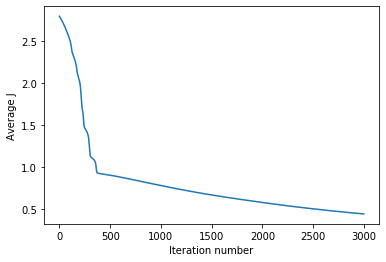

In [52]:
# You can see the average cost function decreased as we went through
# the gradient descent iterations of the training, slowly converging on a minimum in the
# function:

plt.plot(avg_cost_func)
plt.ylabel("Average J")
plt.xlabel("Iteration number")
plt.show()

1.5.5 Assessing the Accuracy of the trained model

In [53]:
def predict_y(W,b,X,n_layers):
    m = X.shape[0]
    y = np.zeros((m,))
    for i in range(m):
        h,z = feed_forward(X[i, :], W, b)
        y[i] = np.argmax(h[n_layers])
    return y

Finally, we can assess the accuracy of the prediction (i.e. the percentage of times the
network predicted the handwritten digit correctly), by using the scikit learn
accuracy_score function:

In [54]:
from sklearn.metrics import accuracy_score
y_pred = predict_y(W, b, X_test, 3)
accuracy_score(y_test, y_pred)*100

86.92628650904032